# [EX_17]MOVIE_RECOMMENDATION
* Movielens 1M Dataset을 기반으로 Session Based Reccomenation 시스템을 제작해 봄

###목차 -----------------------------
* STEP 0. 환경설정
* STEP 1. 데이터 전처리
* STEP 2. 미니배치 구성
* STEP 3. 모델 구성
* STEP 4. 모델 학습
* STEP 5. 모델 테스트

* 루브릭
* 회고
### ---------------------------------

## STEP 0. 환경 설정

In [6]:
# 필요 라이브러리 임포트

import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import tensorflow

print(pd.__version__)
print(tensorflow.__version__)

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt


1.3.3
2.6.0


## STEP 1. 데이터 로드 및 전처리

* Sequential Recommendation - 사용자에 대한 정보를 알 수 있는 경우
* Context-Aware : 사용자와 아이템 추가 정보를 Sequential Recommendation 모델에 적용하는 분야
* E-Commerce 데이타의 특징
1. 비로그인 상태로 탐색하는 사용자 많음
2. 로그인해서 탐색하는 경우도 접속 때마다 탐색의도가 명확하게 다름.-> 마우스 구매를 위해 탐색한 이력이 칫솔 구매를 위한 탐색에 도움이 되지 않음.

### S1-1. Data Load
* 추천시스템 구축 시 확인 데이터 : 유저(세션)수, 아이템수
* Session_lengh : 각 세션별 데이터 수. Sessionid를 공유하는 데이터 row의 개수.-> 해당 세션의 사용자가 그 세션 동안 몇 번의 액션을 취했는지(몇 개의 상품정보를 클릭했는지)의 의미가 됨 

  * Sessionid : 브라우저에서 웹서버로 접속할 때 항상 포함되는 유저 구분자. 로그인하지 않아 사용자가 누구인지는 알 수 없지만, 최소한 특정 사용자의 행동을 Sessionid 기준으로 모아서 분류해 낼 수는 있음
* 사용자들의 서비스 이용형태는 다양하므로 전처리 방법에 대해서는 모델 만드는 사람이 판단 영역 : 짧은 시간에 매우 많은 액션을 취하는 사용자(세션id)를 제거해야할까? 포함시켜야할까? 
=> 시각화 : '분포 누적합' cumsum()

* 사용자 sessionid - 액션수 sessin_lengh(클릭한 상품정보) 관계에 대해 Matrix Factorization을 사용하면??
=> User * Item Matrix의 빈칸이 너무 많아서(data sparsity 데이타 희소) 모델이 제대로 학습되지 않을 가능성이 있음
=> 세션 정보는 사용자 ID 기반으로 정리할 수 없기 때문에 세션 하나를 사용자 하나로 본다면 기존의 사용자-상품정보 Matrix보다 훨씬 sparse한(희소) 형태가 됨.

* Seesion TIme 데이터가 발생한 시간
  * 사용자들의 소비 패턴은 빨리 변함
  => 추천시스템 구축 시 최근 소비 트렌드를 학습하는 것이 중요함.
  * 데이터의 시간 관련 정보는?
  => timestamp객체로 저장 
  => int와 사칙연산 지원하지 않음 
  => 날짜끼리 차이 : datetime.timedelta( )사용




In [13]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [14]:
# 추천시스템 구축 시 가장 중요한 데이터 : 유저 수(세션 수)와 아이템 수 확인

data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [15]:
# Session_length 확인

session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [16]:
# Session_lenght에 대해 기본 통계 확인 : 중간값, 평균값

session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [17]:
# Session_lenght에 대해 기본 통계 확인 : 최소값, 최댓값

session_length.min(), session_length.max()

(20, 2314)

In [18]:
# Session_lenght에 대해 기본 통계 확인 : 사분위수

session_length.quantile(0.999)

1343.181000000005

In [19]:
# 길이 max(액션이 2314번)인 값에 대한 내용 확인

long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


##### UserID를 이용해 세션길이에 대한 처리
* SessionID대신 UserID를 사용
* UserID : 브라우저에서 웹서버로 접속할 때 포함되는 사용자 구분자.
* 같은 UserID인 데이터의 개수

In [20]:
# 세션 길이에 대한 시각화 : 분포 누적합 cumsum()

length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

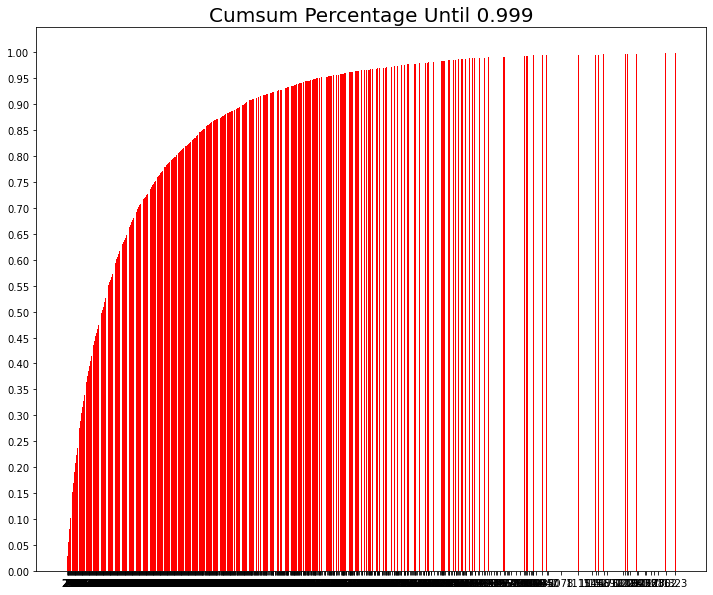

In [21]:
plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

##### 시간 정보에 대한 처리
* 데이터의 시간 관련 정보는? => timestamp객체로 저장 => int와 사칙연산 지원하지 않음 => 날짜끼리 차이 : datetime.timedelta( )사용

In [22]:
# # 시간 관련 정보 확인

# oldest, latest = data['Time'].min(), data['Time'].max()
# print(oldest) 
# print(latest)

change_date = []
for time in data['Time']:
    temp = dt.datetime.fromtimestamp(time)
    change_date.append(temp)

data['Time'] = change_date
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43


In [24]:
# 시간 정보의 데이터형식 확인
# lastest는 Timestamp객체미므로 int객체와의 사칙연산을 지원하지 않음
# 날짜끼리의 차이를 구할 때 => datetime라이브러리의 timedelta객체 사용

oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


##### Rating 정보에 대한 처리
* 평점의 분포를 살펴본 후 사용 기준을 정해 봄


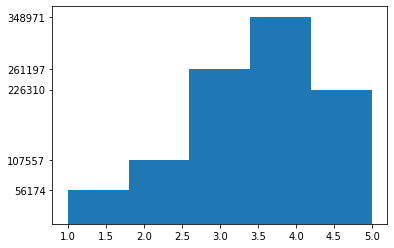

In [25]:
# 평점 데이터의 분포를 살펴 봄

plt.hist(data['Rating'], bins=5)
plt.yticks(data['Rating'].value_counts())
plt.show()

In [26]:
# Rating 이 3이상인 데이터만 남김
# Rating 이 낮은 데이터들은 ??

data = data[data['Rating']>=4]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 575281 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   UserId  575281 non-null  int32         
 1   ItemId  575281 non-null  int32         
 2   Rating  575281 non-null  int32         
 3   Time    575281 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(3)
memory usage: 15.4 MB


### S1-2. Data Cleansing
* 모델의 목적 : 사용자가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것 => 길이 1인 세션은 제거
* 너무 적게 클릭된 아이템도 이상한 아이템일 가능성이 높으므로 => 제거

In [27]:
# short_session을 제거한 다음 unpopular item을 제거하면 
# 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.

def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [28]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
36,1,1836,5,2000-12-31 22:02:52
...,...,...,...,...
1000119,6040,3671,4,2001-08-10 14:39:27
999923,6040,232,5,2001-08-10 14:39:58
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04


### S1-3. 데이터셋 분리 - Train/Valid/Test Split

* 추천시스템은 현재 시점에 잘 예측하는 것이 중요
=> 사용자들의 소비패턴이 빨리 바뀌므로 1달 전에 성능이 좋은 모델을 지금 쓰면 맞지 않을 수 있음. 
=> Session-Based Recommendtaion에서는 기간에 따라 Train/Validation/Test 데이터셋을 분리하기도 함

In [31]:
# # 데이터셋 분리를 위해 내용 확인해 봄

# test_path = data_path / 'yoochoose-test.dat'
# test= load_data(test_path)
# test['Time'].min(), test['Time'].max()

data = data.sort_values('Time')
data.head(20)

,UserId,ItemId,Rating,Time
1000138,6040,858,4,2000-04-25 23:05:32
999873,6040,593,5,2000-04-25 23:05:54
1000153,6040,2384,4,2000-04-25 23:05:54
1000007,6040,1961,4,2000-04-25 23:06:17
1000192,6040,2019,5,2000-04-25 23:06:17
999967,6040,3111,5,2000-04-25 23:07:36
999868,6040,573,4,2000-04-25 23:07:36
999920,6040,213,5,2000-04-25 23:07:36
999980,6040,3505,4,2000-04-25 23:07:36
999971,6040,2503,5,2000-04-25 23:09:51


In [45]:
# 기간에 따라 데이터셋을 분리해 줌
# 1~28 : Train, 29 : Valid, 30 : Test

def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('Time')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['Time'].isin(session_in_train)]
    after_date = data[data['Time'].isin(session_in_test)]
    
    return before_date, after_date

In [46]:
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

In [47]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [48]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 563297
	 Sessions: 6034
	 Items: 3125
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-05 03:58:17

* valid Set Stats Info
	 Events: 6311
	 Sessions: 367
	 Items: 1895
	 First Time : 2002-03-05 04:38:49
	 Last Time : 2002-09-01 04:20:59

* test Set Stats Info
	 Events: 4776
	 Sessions: 313
	 Items: 1558
	 First Time : 2002-09-01 19:43:16
	 Last Time : 2003-02-28 17:49:50



In [49]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.

id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [57]:
# 데이터 저장

save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## STEP 2. Data Pipeline : 미니배치 
* Session-Paralle Mini-Batch

### S2-1. SessionDataset : 데이터가 주어지면 '세션이 시작되는 인덱스를 담는 값'과 '세션을 새로 인덱싱한 값'을 갖는 클래스를 만듬
* SeesionDataset 
  * click_offset : 각 세션 시작 인덱스
  * session_idx : 각 세션을 인덱싱한 nd.array
  

In [58]:
# SessionDataset 클래스 만듬

class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [59]:
# SessionDataset 객체 만들고, 인스턴스 변수 확인

tr_dataset = SessionDataset(tr)
tr_dataset.df.head(20)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000153,6040,2384,4,2000-04-25 23:05:54,2
1000007,6040,1961,4,2000-04-25 23:06:17,3
1000192,6040,2019,5,2000-04-25 23:06:17,4
999967,6040,3111,5,2000-04-25 23:07:36,5
999868,6040,573,4,2000-04-25 23:07:36,6
999920,6040,213,5,2000-04-25 23:07:36,7
999980,6040,3505,4,2000-04-25 23:07:36,8
999971,6040,2503,5,2000-04-25 23:09:51,9


In [60]:
tr_dataset.click_offsets

array([     0,     45,    118, ..., 562994, 563084, 563297], dtype=int32)

In [61]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6031, 6032, 6033])

### S2-2. SessionDataLoader
* SessionDataset 객체 받아서 Session-Pararell mini-batch만드는 클래스 만듬
  * __iter__ 메서드 : 모델 input, label, session 끝난 곳 위치 yield함
  * mask : 나중에 RNN Cell State를 초기화

In [62]:
# SessionDataLoader 클래스 

class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [63]:
# SeesionDataLoader 객체 만들고 내용 확인

tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000153,6040,2384,4,2000-04-25 23:05:54,2
1000007,6040,1961,4,2000-04-25 23:06:17,3
1000192,6040,2019,5,2000-04-25 23:06:17,4
999967,6040,3111,5,2000-04-25 23:07:36,5
999868,6040,573,4,2000-04-25 23:07:36,6
999920,6040,213,5,2000-04-25 23:07:36,7
999980,6040,3505,4,2000-04-25 23:07:36,8
999971,6040,2503,5,2000-04-25 23:09:51,9


In [64]:
# 데이터 로드해주는 객체를 iter에 넣어서 할당함

iter_ex = iter(tr_data_loader)

In [65]:
# 데이터를 계속 생성해 줌

inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  45 116 138]
Label Item Idx are :       [  1  46 117 139]
Previous Masked Input Idx are []


## STEP 3. 모델 구성
* RNN 계열 모델 중 GRU 적용
* Embedding Layer 사용않고 OHE만 사용함
* 추천 데이터의 특징 살려 모델링
  * Session의 길이가 대부분 짧지만 긴 것도 있음 
  => 세션들을 하나의 데이터 샘플 하나로 보고 mini-batch 구성해 input으로 넣으면, 제일 긴 세션의 연산이 끝날 때까지 짧은 세션들이 기다려야 함.
  => Session-Pararell Mini-Batch방식 : 짧은 세션이 끝나면 다른 짧은 세션 이어서 시작하는 병렬 방식
* Sampling on the output : negative sampling과 같은 개념
  * item의 수가 많기 때문에 loss를 계산할 때 모든 아이템을 비교하지 않고 인기도를 고려해 sampling -> 이번 노드에선 반영하지 않음
* ranking loss : session-based recommendtaion 
  * task를 여러 아이템 중 다음 아이템이 무엇인지 classification 하는 task로 생각할 수도 있음
  * 여러 아이템을 관련도 순으로 랭킹을 매겨서 높은 랭킹의 아이템을 추천한느 task로 생각할 수도 있음 => 추천 시스템 분야에서 이런 objective function에 대한 연구가 있었고, 논문에서도 사용함
  * 이번 노드에서는 classificaiton task로 보고 cross-entropy를 사용함

### S3-1. Evaluation Metric
* 모델 성능 평가 지표
  * precision 정밀도 : 긍정으로 예측한 것 중에 양성인 것
  * recall 재현율 : 양성인 것들 중 긍정으로 예측한 것

* Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 사용자가 클릭/구매한 n개의 아이템이 많아야 좋음. 즉 사용자의 선호도가 반영되어야 의미가 있음 =>
  * recall@k : recall 개념 확장한 지표
  * Mean Average Precision : precision 개념 확장 지표
* 추천에서는 몇 번째로 맞추느냐도 중요=> 순서에 민감한 지표 사용
  * MRR mean reciprocal rank - 여러개의 쿼리를 날려 나온 점수들의 평균을 취한 값
  * NDCG

! 추천시스템의 평가 시스템
1) Ranking기반 추천 시스템 -> Precision/Recall@K, NDCG@K, Hit Rate
2) 평점 예측 기반 추천 시스템 -> MAE, RMSE
Recall/Precision@K 

! 머신러닝 평가 지표로 많이 사용되는 Precision, Recall이 이진분류에 사용되는 것에 비해, 추천 시스템은 하나의 아이템만 추천하지는 않으며, 정답도 여러 개가 될 수 있음 => K는 추천 아이템 수를 의미함
  * Recall@K : 실제 모든 1 중에서 내가 1로 예측한 것이 얼마나 되는지 비율
    -> 사용자가 관심있는 모든 아이템 중에서 내가 추천한 아이템 K개가 얼마나 포함되는지 비율
  * Precision@K : 내가 1로 예측한 것 중에 실제 1이 얼마나 있는지 비율
    -> 내가 추천한 아이템 K개 중에 실제 사용자가 관심있는 아이템의 비율

In [78]:
# 평가 지표 정의

def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### S3-2. Model Architecture

In [79]:
# 모델 구조 구현을 위한 라이브러리 임포트

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [80]:
# 모델 구조 구현

def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [82]:
# 모델에 사용할 hyper-parameter를 관리하기 위한 class 만듬

class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k
        
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [83]:
# 모델 생성

model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(256, 1, 3125)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    476550    
_________________________________________________________________
dropout_1 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (256, 3125)               159375    
Total params: 635,925
Trainable params: 635,925
Non-trainable params: 0
_________________________________________________________________


### S3-3. Model Training

In [84]:
# 학습을 위한 함수 정의

# train 셋으로 학습하면서 valid 셋으로 검증합니다.
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

## STEP 4. 모델 학습

In [85]:
# 모델 학습 

train_model(model, args)
## 학습된 모델을 불러옵니다.
# model = tf.keras.models.load_model(data_path / 'trained_model')


Evaluation:   9%|▊         | 2/23 [00:02<00:28,  1.38s/it]


	 - Recall@20 epoch 1: 0.046875
	 - MRR@20    epoch 1: 0.011312



Evaluation:   9%|▊         | 2/23 [00:02<00:23,  1.12s/it]


	 - Recall@20 epoch 2: 0.064453
	 - MRR@20    epoch 2: 0.008248



Evaluation:   9%|▊         | 2/23 [00:02<00:23,  1.11s/it]

	 - Recall@20 epoch 3: 0.068359
	 - MRR@20    epoch 3: 0.016032



## STEP 5. 모델 테스트

* 테스트셋에 대해 어느 정도 성능 내는지 검증

In [86]:
# 기본 

def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:   6%|▌         | 1/17 [00:01<00:17,  1.10s/it]

	 - Recall@20: 0.074219
	 - MRR@20: 0.011382



### S5-1. 1st Try
##### Hyper Parameter setting
* batch size : 256
* hsz : 50
* drop_rate : 0.3
* Iearning Rate : 0.1
* epoch : 3
* k : 20

In [87]:
# 1st try

args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.3, lr=0.1, epochs=3, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(256, 1, 3125)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    476550    
_________________________________________________________________
dropout_2 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (256, 3125)               159375    
Total params: 635,925
Trainable params: 635,925
Non-trainable params: 0
_________________________________________________________________


Evaluation:   9%|▊         | 2/23 [00:02<00:25,  1.20s/it]


	 - Recall@20 epoch 1: 0.041016
	 - MRR@20    epoch 1: 0.009088



Evaluation:   9%|▊         | 2/23 [00:02<00:23,  1.10s/it]


	 - Recall@20 epoch 2: 0.050781
	 - MRR@20    epoch 2: 0.009698



Evaluation:   9%|▊         | 2/23 [00:02<00:23,  1.12s/it]

	 - Recall@20 epoch 3: 0.052734
	 - MRR@20    epoch 3: 0.013215



## S5-2. 2nd Try
##### Hyper Parameter setting
* batch size : 128
* hsz : 100
* drop_rate : 0.3
* Iearning Rate : 0.1
* epoch : 3
* k : 20

In [89]:
# 2nd Try

args = Args(tr, val, test, batch_size=128, hsz=100, drop_rate=0.3, lr=0.1, epochs=3, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(128, 1, 3125)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 100), (128, 100)]  968100    
_________________________________________________________________
dropout_4 (Dropout)          (128, 100)                0         
_________________________________________________________________
dense_4 (Dense)              (128, 3125)               315625    
Total params: 1,283,725
Trainable params: 1,283,725
Non-trainable params: 0
_________________________________________________________________


Evaluation:  43%|████▎     | 20/46 [00:11<00:15,  1.71it/s]


	 - Recall@20 epoch 1: 0.044141
	 - MRR@20    epoch 1: 0.010604



Evaluation:  43%|████▎     | 20/46 [00:11<00:14,  1.75it/s]


	 - Recall@20 epoch 2: 0.041797
	 - MRR@20    epoch 2: 0.009066



Evaluation:  43%|████▎     | 20/46 [00:11<00:14,  1.76it/s]

	 - Recall@20 epoch 3: 0.044531
	 - MRR@20    epoch 3: 0.010874



In [ ]:
### S5-3. 3rd Try
##### Hyper Parameter setting
* batch size : 256
* hsz : 100
* drop_rate : 0.3
* Iearning Rate : 0.1
* epoch : 3
* k : 20

In [90]:
# 3rd Try

args = Args(tr, val, test, batch_size=256, hsz=100, drop_rate=0.3, lr=0.1, epochs=3, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(256, 1, 3125)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 100), (256, 100)]  968100    
_________________________________________________________________
dropout_5 (Dropout)          (256, 100)                0         
_________________________________________________________________
dense_5 (Dense)              (256, 3125)               315625    
Total params: 1,283,725
Trainable params: 1,283,725
Non-trainable params: 0
_________________________________________________________________


Evaluation:   9%|▊         | 2/23 [00:02<00:25,  1.22s/it]


	 - Recall@20 epoch 1: 0.025391
	 - MRR@20    epoch 1: 0.005869



Evaluation:   9%|▊         | 2/23 [00:02<00:23,  1.11s/it]


	 - Recall@20 epoch 2: 0.033203
	 - MRR@20    epoch 2: 0.004948



Evaluation:   9%|▊         | 2/23 [00:02<00:23,  1.12s/it]

	 - Recall@20 epoch 3: 0.037109
	 - MRR@20    epoch 3: 0.004315



In [ ]:
### S5-4. 4th Try
##### Hyper Parameter setting
* batch size : 128
* hsz : 200
* drop_rate : 0.3
* Iearning Rate : 0.1
* epoch : 3
* k : 20

In [92]:
# 4th Try

args = Args(tr, val, test, batch_size=128, hsz=200, drop_rate=0.3, lr=0.1, epochs=3, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(128, 1, 3125)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 200), (128, 200)]  1996200   
_________________________________________________________________
dropout_6 (Dropout)          (128, 200)                0         
_________________________________________________________________
dense_6 (Dense)              (128, 3125)               628125    
Total params: 2,624,325
Trainable params: 2,624,325
Non-trainable params: 0
_________________________________________________________________


Evaluation:  43%|████▎     | 20/46 [00:11<00:15,  1.70it/s]


	 - Recall@20 epoch 1: 0.041797
	 - MRR@20    epoch 1: 0.009093



Evaluation:  43%|████▎     | 20/46 [00:11<00:14,  1.76it/s]


	 - Recall@20 epoch 2: 0.041406
	 - MRR@20    epoch 2: 0.009434



Evaluation:  43%|████▎     | 20/46 [00:11<00:14,  1.77it/s]

	 - Recall@20 epoch 3: 0.044922
	 - MRR@20    epoch 3: 0.009894



## [ 루브릭 ]
1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행함.
2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련을 진행함
3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰함
---
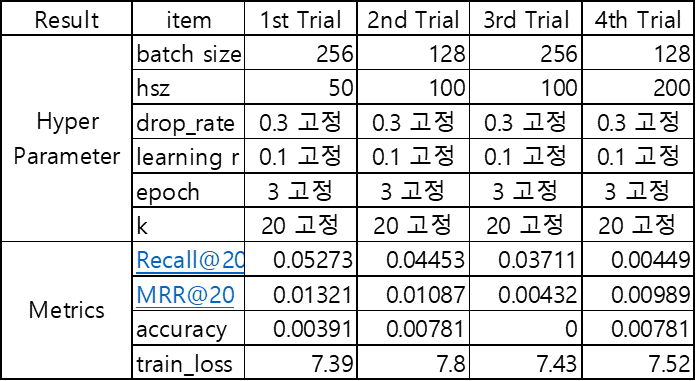

## [ 회고 ]
* 웹 서비스에서 사용자의 행동패턴에 대한 정보, 특히 로그인 하지않은 사용자에 대한 정보를<br> 
이용하는 것에 대해서는 알고 있었지만, 실제로 어떤 방법으로 이용하는지에 대해서는 이번 노드를<br>
통해서 알 수 있게 되었는데, 나중에 유용하게 사용할 수 있을 것 같다.
* 다만, 모델에 대한 이해는 많이 부족한 상태라서 공부를 더 해야할 필요가 있고, 이번 프로젝트는 노드의<br>
내용에서 크게 벗어나지 않고 구현된 내용을 이해하는데 목표를 두었다.
* 무엇보다 모델의 성능을 높이기 위해 모델을 구성하고 최적의 파라미터를 설정하는 방법에 대해서는 감을 잡지<br>
못하고 있어서 아쉽다.